In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from scipy.optimize import brentq
from scipy.stats import norm

In [4]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

def find_vol( S, K, r, T, market_price, option_type='call'):
    def objective_function(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price

    try:
        implied_vol = brentq(objective_function, 1e-6, 10)  # You might need to adjust these bounds
    except ValueError as e:
        # Handle the case where the function doesn't cross zero in the provided interval
        print(f"Could not find root within bounds for strike {K} and market price {market_price}.")
        implied_vol = np.nan  # Return NaN or some other placeholder value

    return implied_vol

## Option Pricing with stochastic liquidity

In [3]:
from stochastic_liquidity import (
    MC_stochastic_liquidity,
    price_closed_form_stochastic_liquidity
    )

In [9]:
# Example usage
r = 0.01  # risk-free rate
sigma = 0.2 # volatility
beta = 0.5
alpha = 0.2
xi = 0.9 # market liquidity volatility
theta = 0.3  # equilibrium level of market liquidity
rho_gamma_s = 0.2
rho_l_s = 0.2
rho_gamma_l = 0.2
tau = 1.0  # time to maturity in years
liquidity = 0.3  # initial liquidity
S = 100  # current stock price
K = 110  # strike price

### Numerical simulation

#### Convergence of numerical simulation

In [6]:
st = MC_stochastic_liquidity(S, K, tau, r, sigma, beta, alpha, theta, xi, rho_gamma_s, rho_l_s, rho_gamma_l, liquidity, 1000)

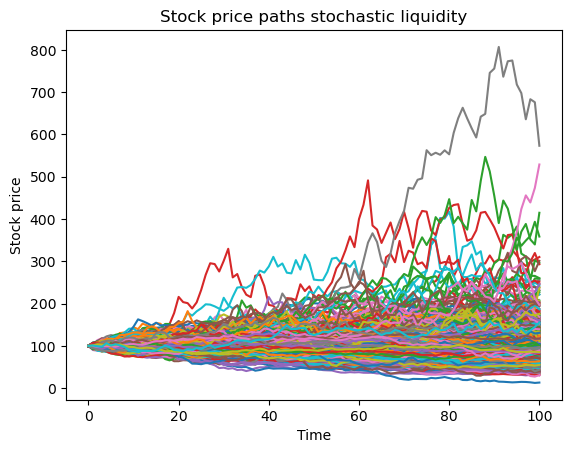

In [10]:
plt.plot(range(101), st[:].T)
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.title('Stock price paths stochastic liquidity')
plt.show()

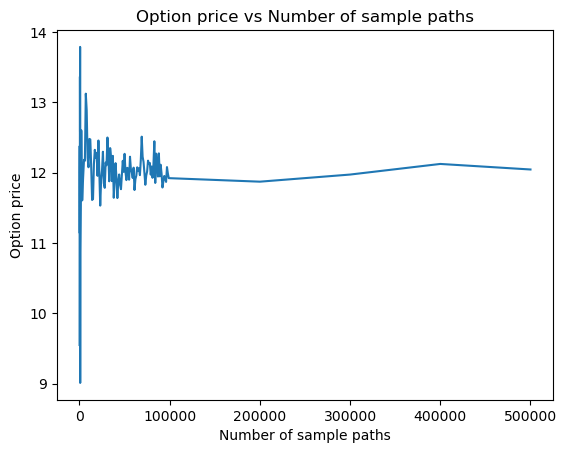

In [ ]:
N = np.concatenate((np.arange(100, 1000, 100), np.arange(2000, 100000, 1000), [200000, 300000, 400000, 500000]))
Mc = np.zeros(len(N))

for i in range(len(N)):
    # Price the European call option
    Mc[i] = MC_stochastic_liquidity(S, K, tau, r, sigma, beta, alpha, theta, xi, rho_gamma_s, rho_l_s, rho_gamma_l, liquidity, N[i])

plt.plot(N, Mc)
plt.xlabel('Number of sample paths')
plt.ylabel('Option price')
plt.title('Option price vs Number of sample paths')
plt.show()

### Analytically pricing the options with closed form equation

In [807]:
price = price_closed_form_stochastic_liquidity(r, sigma, beta, alpha, xi, theta, rho_gamma_s, rho_l_s, rho_gamma_l, tau, liquidity, S, K)
print(f"The European option price is: {price}")

The European option price is: 12.030870399314232


### Comparing results of simulation and analytical methods

In [814]:
### Comparing results of simulation and analytical methods
K_list = list(np.linspace(80, 120, 9))
taulist = list(np.linspace(0.2, 1, 5))
taulist = [round(i, 2) for i in taulist]
simulated_values = np.zeros((len(taulist), len(K_list)))
analytical_values = np.zeros((len(taulist), len(K_list)))
relative_error = np.zeros((len(taulist), len(K_list)))

In [873]:
for i in range(len(taulist)):
    simulated_values[i, :] = MC_stochastic_liquidity(S, K_list, taulist[i], r, sigma, beta, alpha, theta, xi, rho_gamma_s, rho_l_s, rho_gamma_l, liquidity, 150000)
    for j in range(len(K_list)):
        analytical_values[i, j] = price_closed_form_stochastic_liquidity(r, sigma, beta, alpha, xi, theta, rho_gamma_s, rho_l_s, rho_gamma_l, taulist[i], liquidity, S, K_list[j])
        relative_error[i, j] = np.abs((simulated_values[i, j] - analytical_values[i, j]) / analytical_values[i, j])

In [874]:
df_re = pd.DataFrame(relative_error, index=taulist, columns=K_list)
df_re.index.name = 'tau'
df_re.columns.name = 'k'

df_analytical = pd.DataFrame(analytical_values, index=taulist, columns=K_list)
df_analytical.index.name = 'tau'
df_analytical.columns.name = 'k'

df_simulated = pd.DataFrame(simulated_values, index=taulist, columns=K_list)
df_simulated.index.name = 'tau'
df_simulated.columns.name = 'k'

In [875]:
# Combine the dataframes into a single structured table format
table_list = [f"τ = {i} \n" + "Analytical: \n" + "Simulated: \n" + "Relative Error (%) \n" for i in taulist]
combined_table = pd.DataFrame(index=df_analytical.index)

for column in df_analytical.columns:
    combined_table[f'{column}'] = ("-----\n" + df_analytical[column].round(3).astype(str) + 
                                          "\n" + df_simulated[column].round(3).astype(str) + 
                                          "\n" + (df_re[column]*100).round(3).astype(str) )

combined_table.index = table_list
combined_table.index.name = 'S0/K'

# Print the table
print(tabulate(combined_table, headers='keys', tablefmt='grid'))

+--------------------+--------+--------+--------+--------+---------+---------+---------+---------+---------+
| S0/K               | 80.0   | 85.0   | 90.0   | 95.0   | 100.0   | 105.0   | 110.0   | 115.0   | 120.0   |
+====================+========+========+========+========+=========+=========+=========+=========+=========+
| τ = 0.2            | -----  | -----  | -----  | -----  | -----   | -----   | -----   | -----   | -----   |
| Analytical:        | 20.382 | 15.778 | 11.619 | 8.123  | 5.419   | 3.488   | 2.199   | 1.376   | 0.863   |
| Simulated:         | 20.363 | 15.762 | 11.604 | 8.107  | 5.403   | 3.476   | 2.189   | 1.367   | 0.857   |
| Relative Error (%) | 0.094  | 0.104  | 0.125  | 0.193  | 0.288   | 0.364   | 0.435   | 0.598   | 0.674   |
+--------------------+--------+--------+--------+--------+---------+---------+---------+---------+---------+
| τ = 0.4            | -----  | -----  | -----  | -----  | -----   | -----   | -----   | -----   | -----   |
| Analytical:      

### Calibrating on real world data

In [34]:
# Load data
data = np.loadtxt('in_sample_settle/2017-01-25.csv', delimiter=',', skiprows=1)
x = np.load('optimized_parameters_stochastic_liquidity.npy')
x

array([ 0.12649169,  0.02007989,  0.58194017,  0.18001997,  9.02527767,
        0.43886554, -0.38964633,  0.05499114,  0.27360334])

Date: 0.07945205479452055
Could not find root within bounds for strike 6400.0 and market price 2233.181526912662.
Could not find root within bounds for strike 6500.0 and market price 2090.25.


/var/folders/8s/bn80713540zf4v83t3yg2lmc0000gn/T/ipykernel_38053/590273176.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('K', inplace=True)


Could not find root within bounds for strike 6650.0 and market price 1984.3640444909925.
Could not find root within bounds for strike 6700.0 and market price 1934.5892414528307.
Could not find root within bounds for strike 6750.0 and market price 1884.8274574327806.
Could not find root within bounds for strike 6800.0 and market price 1766.0.
Could not find root within bounds for strike 6800.0 and market price 1835.078287146801.
Could not find root within bounds for strike 7000.0 and market price 1597.55.
Could not find root within bounds for strike 7050.0 and market price 1537.0.
Could not find root within bounds for strike 7050.0 and market price 1586.2772867083304.
Could not find root within bounds for strike 7100.0 and market price 1498.05.
Could not find root within bounds for strike 7100.0 and market price 1536.4980352827688.
Could not find root within bounds for strike 7150.0 and market price 1486.7273641034117.
Could not find root within bounds for strike 7200.0 and market price

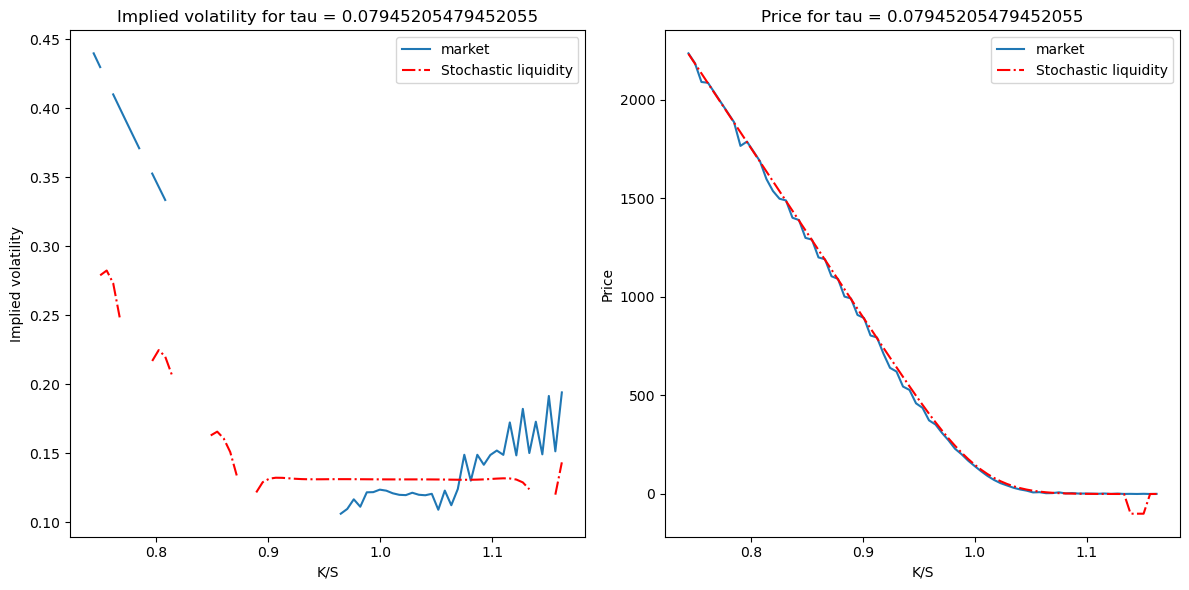

Date: 0.17534246575342466
Could not find root within bounds for strike 5100.0 and market price 3463.15.
Could not find root within bounds for strike 5200.0 and market price 3457.1700818479694.
Could not find root within bounds for strike 5300.0 and market price 3358.2166199818794.
Could not find root within bounds for strike 5600.0 and market price 3061.3562394399296.
Could not find root within bounds for strike 5900.0 and market price 2764.4958619498866.
Could not find root within bounds for strike 6000.0 and market price 2596.0.
Could not find root within bounds for strike 6000.0 and market price 2665.5423998617325.
Could not find root within bounds for strike 6300.0 and market price 2368.6820215307507.
Could not find root within bounds for strike 6400.0 and market price 2269.728562110622.
Could not find root within bounds for strike 6500.0 and market price 2035.0.
Could not find root within bounds for strike 7000.0 and market price 1657.9.
Could not find root within bounds for strik

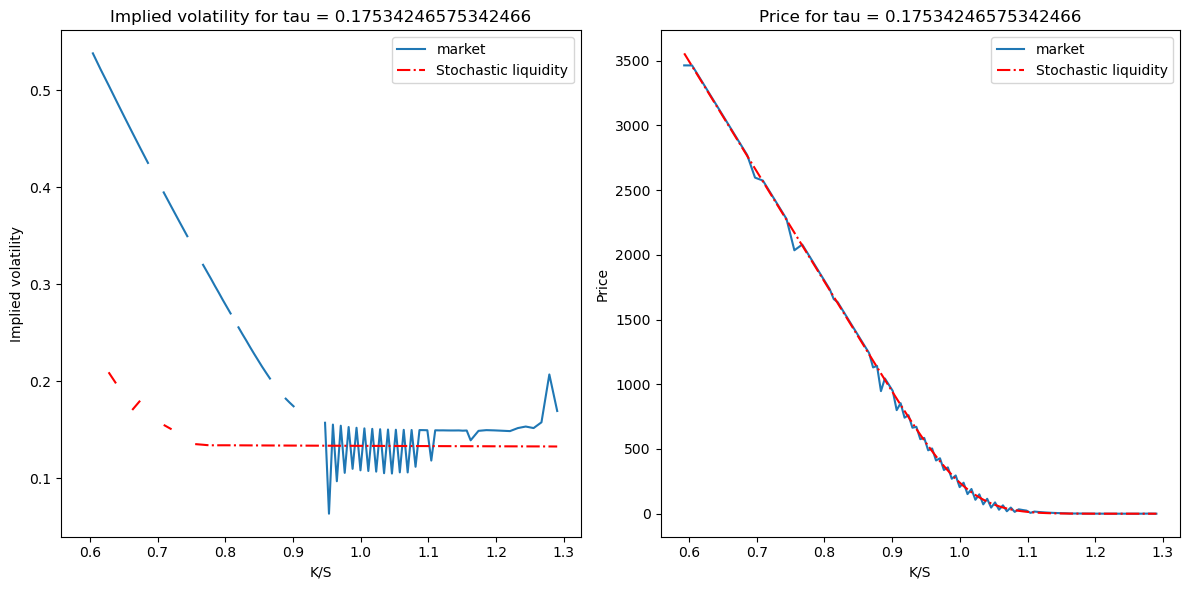

In [35]:
df_data = pd.DataFrame(data, columns=['Tau', 'S', 'C', 'K', 'r'])
for date in df_data['Tau'].unique():
    print(f"Date: {date}")
    df = df_data[df_data['Tau'] == date]
    # df_close = df_data[df_data['Tau'] == date]

    df.sort_values('K', inplace=True)
    # df_close.sort_values('K', inplace=True)
    data = df.values
    data[:,4] = 0.06
    # data_close = df_close.values

    # Initialize lists to store results
    strike = []
    imv_market = []
    imv_close = []
    our_price = []
    imv_our = []

    # Loop over the data
    for i in range(len(data)):
            strike.append(data[i, 3])
            imv_market.append(find_vol(data[i, 1], data[i, 3], data[i, 4], data[i, 0], data[i, 2]))
            # imv_close.append(find_vol(data[i, 1], data[i, 3], data[i, 4], data[i, 0], data_close[i, 2]))
            our_p = price_closed_form_stochastic_liquidity(data[i, 4], x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], data[i, 0], x[8], data[i, 1], data[i, 3])
            our_price.append(our_p)
            imv_our.append(find_vol(data[i, 1], data[i, 3], data[i, 4], data[i, 0], our_p))

    # Convert lists to numpy arrays for plotting
    strike = np.array(strike)
    imv_market = np.array(imv_market)
    imv_our = np.array(imv_our)
    # imv_close = np.array(imv_close)

    # Plot the results
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(strike / data[0, 1], imv_market, label='market')
    axs[0].plot(strike / data[0, 1], imv_our, 'r-.', label='Stochastic liquidity')
    # axs[0].plot(strike / data[0, 1], imv_close, 'g--', label='Close price')
    axs[0].set_xlabel('K/S')
    axs[0].set_ylabel('Implied volatility')
    axs[0].set_title(f'Implied volatility for tau = {data[0, 0]}')
    axs[0].legend()

    axs[1].plot(strike / data[0, 1], data[:,2], label='market')
    axs[1].plot(strike / data[0, 1], our_price, 'r-.', label='Stochastic liquidity')
    # axs[1].plot(strike / data[0, 1], data_close[:,2], 'g--', label='Close price')
    axs[1].set_xlabel('K/S')
    axs[1].set_ylabel('Price')
    axs[1].set_title(f'Price for tau = {data[0, 0]}')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

## Option Pricing with stochastic liquidity and regime changes

In [6]:
from stochastic_liquidity_and_regime_switching import (
    MC_sotchastic_liquidity_and_regime_switching,
    price_closed_form_stochastic_liquidity_and_regime_switching,
    )

In [7]:
r = 0.03
sigma1 = 0.1
sigma2 = 0.2
lambda12 = 1.0
lambda21 = 1.0
beta = 0.8
k = 1.0
alpha = 0.5
eta = 0.2
rho = -0.5
tau = 1.0
liquidity = 0.3
S = 100
K = 100

### Numerical simulation

#### Convergence of numerical simulation

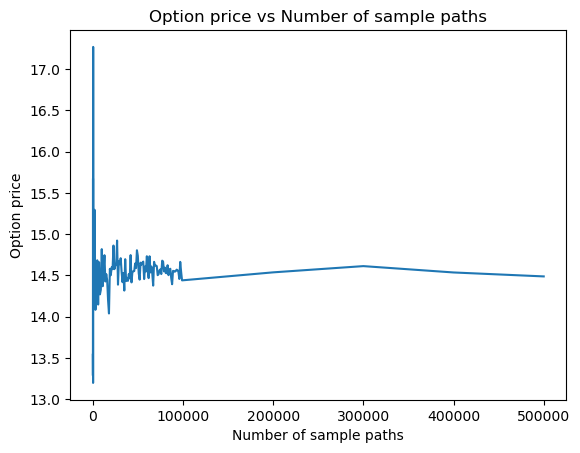

In [ ]:
N = np.concatenate((np.arange(100, 1000, 100), np.arange(2000, 100000, 1000), [200000, 300000, 400000, 500000]))
Mc = np.zeros(len(N))
conf = np.zeros(len(N))

for i in range(len(N)):
    Mc[i], conf[i] = MC_sotchastic_liquidity_and_regime_switching(r, sigma1, sigma2, lambda12, lambda21, beta, k, alpha, eta, rho, tau, liquidity, S, K, N[i])

plt.plot(N, Mc)
plt.xlabel('Number of sample paths')
plt.ylabel('Option price')
plt.title('Option price vs Number of sample paths')
plt.show()

### Analytically pricing the options with closed form equation

In [6]:
price = price_closed_form_stochastic_liquidity_and_regime_switching(r, sigma1, sigma2, lambda12, lambda21, beta, k, alpha, eta, rho, tau, liquidity, S, K)
print(f"The European option price is: {price}")

The European option price is: 14.545239815852838


### Comparing results of simulation and analytical methods

In [151]:
K_list = list(np.linspace(80, 120, 9))
taulist = list(np.linspace(0.2, 1, 5))
taulist = [round(i, 2) for i in taulist]

In [152]:
simulated_values = np.zeros((len(taulist), len(K_list)))
analytical_values = np.zeros((len(taulist), len(K_list)))
relative_error = np.zeros((len(taulist), len(K_list)))

for i in range(len(taulist)):
    simulated_values[i], _ = MC_sotchastic_liquidity_and_regime_switching(r, sigma1, sigma2, lambda12, lambda21, beta, k, alpha, eta, rho, taulist[i], liquidity, S, K_list, 150000)
    for j in range(len(K_list)):
        analytical_values[i, j] = price_closed_form_stochastic_liquidity_and_regime_switching(r, sigma1, sigma2, lambda12, lambda21, beta, k, alpha, eta, rho, taulist[i], liquidity, S, K_list[j])
        relative_error[i, j] = np.abs((simulated_values[i, j] - analytical_values[i, j]) / analytical_values[i, j])

In [153]:
df_re = pd.DataFrame(relative_error, index=taulist, columns=K_list)
df_re.index.name = 'tau'
df_re.columns.name = 'k'

df_analytical = pd.DataFrame(analytical_values, index=taulist, columns=K_list)
df_analytical.index.name = 'tau'
df_analytical.columns.name = 'k'

df_simulated = pd.DataFrame(simulated_values, index=taulist, columns=K_list)
df_simulated.index.name = 'tau'
df_simulated.columns.name = 'k'

In [154]:
# Combine the dataframes into a single structured table format
table_list = [f"τ = {i} \n" + "Analytical: \n" + "Simulated: \n" + "Relative Error (%) \n" for i in taulist]
combined_table = pd.DataFrame(index=df_analytical.index)

for column in df_analytical.columns:
    combined_table[f'{column}'] = ("-----\n" + df_analytical[column].round(3).astype(str) + 
                                          "\n" + df_simulated[column].round(3).astype(str) + 
                                          "\n" + (df_re[column]*100).round(3).astype(str) )

combined_table.index = table_list
combined_table.index.name = 'K/S0'

# Print the table
print(tabulate(combined_table, headers='keys', tablefmt='grid'))


+--------------------+--------+--------+--------+--------+---------+---------+---------+---------+---------+
| S0/K               | 80.0   | 85.0   | 90.0   | 95.0   | 100.0   | 105.0   | 110.0   | 115.0   | 120.0   |
+====================+========+========+========+========+=========+=========+=========+=========+=========+
| τ = 0.2            | -----  | -----  | -----  | -----  | -----   | -----   | -----   | -----   | -----   |
| Analytical:        | 20.723 | 16.124 | 11.897 | 8.231  | 5.284   | 3.121   | 1.689   | 0.838   | 0.383   |
| Simulated:         | 20.723 | 16.119 | 11.887 | 8.216  | 5.264   | 3.102   | 1.675   | 0.83    | 0.376   |
| Relative Error (%) | 0.002  | 0.028  | 0.086  | 0.183  | 0.368   | 0.59    | 0.834   | 0.924   | 1.876   |
+--------------------+--------+--------+--------+--------+---------+---------+---------+---------+---------+
| τ = 0.4            | -----  | -----  | -----  | -----  | -----   | -----   | -----   | -----   | -----   |
| Analytical:      

### Calibrating on real world data

In [14]:
from nsepython import index_history
import os

In [15]:
# find all files in the directory option_history
files = os.listdir("option_history")
files

['OPTIDX_NIFTY_CE_02-Jan-2017_TO_31-Mar-2017_EXPIRY_25-Jan-2017.csv',
 'OPTIDX_NIFTY_CE_02-Jan-2017_TO_31-Mar-2017_EXPIRY_23-Feb-2017.csv',
 'OPTIDX_NIFTY_CE_02-Jan-2017_TO_31-Mar-2017_EXPIRY_30-Mar-2017.csv']

In [16]:
hist_data = []
for file in files:
    hist_data.append(pd.read_csv(f"option_history/{file}"))
hist_data = pd.concat(hist_data)

In [17]:
# remove leading and trailing whitespaces from the column names
hist_data.columns = hist_data.columns.str.strip()

# convert date and expiry date to datetime
hist_data['Date'] = pd.to_datetime(hist_data['Date'])
hist_data['Expiry'] = pd.to_datetime(hist_data['Expiry'])

# only keep rows where date is a wednesday or thursday
hist_data = hist_data[hist_data['Date'].dt.dayofweek.isin([2, 3])]

# replace '-' with np.nan in the data
hist_data = hist_data.replace('-', np.nan)

 # drop the rows where settle price is nan
hist_data = hist_data[~hist_data['Settle Price'].isnull()] 

# reset the index
hist_data.reset_index(drop=True, inplace=True)

In [18]:
hist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3538 entries, 0 to 3537
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Symbol                            3538 non-null   object        
 1   Date                              3538 non-null   datetime64[ns]
 2   Expiry                            3538 non-null   datetime64[ns]
 3   Option type                       3538 non-null   object        
 4   Strike Price                      3538 non-null   float64       
 5   Open                              1592 non-null   object        
 6   High                              1592 non-null   object        
 7   Low                               1592 non-null   object        
 8   Close                             3538 non-null   float64       
 9   LTP                               1920 non-null   object        
 10  Settle Price                      3538 non-null 

In [19]:
if hist_data['Underlying Value'].isnull().sum() > 0:
    min_date = hist_data['Date'].min()
    max_date = hist_data['Date'].max()
    time_horizon = hist_data['Date'].max() - hist_data['Date'].min()
    underlyings = []
    # If the time horizon is greater than 90 days, split it
    if time_horizon.days > 90:
        current_start = min_date
        
        while current_start < max_date:
            print(current_start)
            current_end = min(current_start + pd.Timedelta(days=90), max_date)
            underlying = index_history('NIFTY 50', str(current_start).split()[0], str(current_end).split()[0])
            underlyings.append(underlying)
            current_start = current_end + pd.Timedelta(days=1)
    else:
        # If time horizon is less than or equal to 90 days, call function once
        underlying = index_history('NIFTY 50', str(min_date).split()[0], str(max_date).split()[0])
        underlyings.append(underlying)

    df_underlying = pd.concat(underlyings)
    df_underlying['HistoricalDate'] = pd.to_datetime(df_underlying['HistoricalDate'])
    df_underlying = df_underlying.sort_values('HistoricalDate')
    df_underlying = df_underlying[['HistoricalDate', 'CLOSE']]
    df_underlying = df_underlying.rename(columns={'HistoricalDate': 'Date', 'CLOSE': 'Underlying Value'})
    df_underlying = df_underlying.reset_index(drop=True)

In [20]:
# replace NaN underlyings with values from the underlying dataframe
for i in range(len(hist_data)):
    if pd.isnull(hist_data.loc[i, 'Underlying Value']):
        date = hist_data.loc[i, 'Date']
        underlying_value = df_underlying[df_underlying['Date'] == date]['Underlying Value'].values[0]
        hist_data.loc[i, 'Underlying Value'] = underlying_value

In [21]:
# Shape the dataframe to keep only relevant columns and reasonable values of Tau
hist_data['Tau'] = (hist_data['Expiry'] - hist_data['Date']).dt.days / 365
hist_data['rate'] = 0.065 # average risk-free rate for the studied period
hist_data = hist_data[['Date', 'Expiry', 'Tau', 'Underlying Value', 'Close', 'Settle Price','Strike Price', 'rate']]
hist_data = hist_data[(hist_data['Tau'] >= 0.05) & (hist_data['Tau'] <= 0.45)]

In [22]:
for date in hist_data['Date'].unique():
    df = hist_data[hist_data['Date'] == date]
    if date.day_of_week == 2:
        df[['Tau', 'Underlying Value', 'Settle Price', 'Strike Price', 'rate']].to_csv(f"in_sample_settle/{date.strftime('%Y-%m-%d')}.csv", index=False)
    elif date.day_of_week == 3:
        df[['Tau', 'Underlying Value', 'Settle Price', 'Strike Price', 'rate']].to_csv(f"out_of_sample_settle/{date.strftime('%Y-%m-%d')}.csv", index=False)

In [15]:
# from our
x = [0.16861523, 0.10040507, 0.55358122, 5.91503753, 0.29529727, 4.95774849, 0.02336233, 0.66556047, 0.29513403, 0.13816121]

In [1]:
# from the paper
x = [0.1527, 0.1248, 5.1209, 4.4388, 0.6127, 4.030, 0.2346, 0.4571, -0.6969, 0.4274]

In [14]:
xv = np.load('optimized_parameters_stochastic_liquidity.npy')
xv

array([ 0.12649169,  0.02007989,  0.58194017,  0.18001997,  9.02527767,
        0.43886554, -0.38964633,  0.05499114,  0.27360334])

In [34]:
from scipy.optimize import brentq
from scipy.stats import norm

/var/folders/8s/bn80713540zf4v83t3yg2lmc0000gn/T/ipykernel_20527/3357157829.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('K', inplace=True)


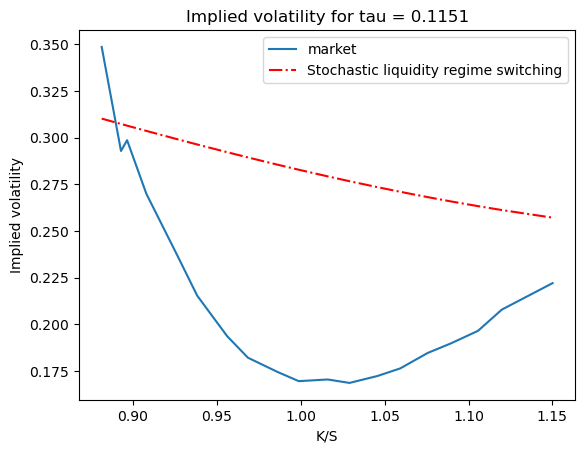

KeyboardInterrupt: 

In [8]:
for i in range(1, 7):
        # Load data
        data = np.loadtxt(f'imv{i}.txt', delimiter=',', skiprows=0)
        # data_close = np.loadtxt('in_sample/2017-01-04.csv', delimiter=',', skiprows=1)

        df_data = pd.DataFrame(data, columns=['Tau', 'S', 'C', 'K', 'r'])
        for date in df_data['Tau'].unique():
                df = df_data[df_data['Tau'] == date]
                # df_close = df_data[df_data['Tau'] == date]

                df.sort_values('K', inplace=True)
                # df_close.sort_values('K', inplace=True)
                data = df.values
                # data_close = df_close.values

                # Initialize lists to store results
                strike = []
                imv_market = []
                imv_close = []
                our_price = []
                imv_our = []

                # Loop over the data
                for i in range(len(data)):
                        strike.append(data[i, 3])
                        imv_market.append(find_vol(data[i, 1], data[i, 3], data[i, 4], data[i, 0], data[i, 2]))
                        # imv_close.append(find_vol(data[i, 1], data[i, 3], data[i, 4], data[i, 0], data_close[i, 2]))
                        our_p = price_closed_form_stochastic_liquidity_and_regime_switching(data[i, 4], x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], data[i, 0], x[9], data[i, 1], data[i, 3])
                        our_price.append(our_p)
                        imv_our.append(find_vol(data[i, 1], data[i, 3], data[i, 4], data[i, 0], our_p))

                # Convert lists to numpy arrays for plotting
                strike = np.array(strike)
                imv_market = np.array(imv_market)
                imv_our = np.array(imv_our)
                # imv_close = np.array(imv_close)

                plt.plot(strike / data[0, 1], imv_market, label='market')
                plt.plot(strike / data[0, 1], imv_our, 'r-.', label='Stochastic liquidity regime switching')
                # axs[0].plot(strike / data[0, 1], imv_close, 'g--', label='Close price')
                plt.xlabel('K/S')
                plt.ylabel('Implied volatility')
                # plt.title(f'Implied volatility for tau = {data[0, 0]}')
                plt.legend()
                plt.show()